In [78]:
!pip install catboost

In [79]:
# Base Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Analysis Libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

# Machine Learning Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# İgnore Warnings
import warnings
warnings.filterwarnings("ignore")

In [80]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [81]:
df = pd.read_csv('Data.csv')

In [82]:
df.head()

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,Outcome Variable
0,Influenza,Yes,No,Yes,Yes,19,Female,Low,Normal,Positive
1,Common Cold,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
2,Eczema,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
3,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive
4,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive


In [83]:
df.shape

(349, 10)

In [84]:
df.rename(columns={
    'Difficulty Breathing': 'DB',
    'Blood Pressure' : 'BP',
    'Cholesterol Level' : 'CL',
    'Outcome Variable' : 'Results'},inplace=True)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Disease  349 non-null    object
 1   Fever    349 non-null    object
 2   Cough    349 non-null    object
 3   Fatigue  349 non-null    object
 4   DB       349 non-null    object
 5   Age      349 non-null    int64 
 6   Gender   349 non-null    object
 7   BP       349 non-null    object
 8   CL       349 non-null    object
 9   Results  349 non-null    object
dtypes: int64(1), object(9)
memory usage: 27.4+ KB


In [86]:
df.groupby(['Gender','Fever']).count()

Disease  Cough  Fatigue  DB  Age  BP  CL  Results
Gender Fever                                                   
Female No          89     89       89  89   89  89  89       89
       Yes         87     87       87  87   87  87  87       87
Male   No          85     85       85  85   85  85  85       85
       Yes         88     88       88  88   88  88  88       88

In [87]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 349
Variables: 10
cat_cols: 8
num_cols: 1
cat_but_car: 1
num_but_cat: 0


In [88]:
cat_cols, num_cols, cat_but_car

(['Fever', 'Cough', 'Fatigue', 'DB', 'Gender', 'BP', 'CL', 'Results'],
 ['Age'],
 ['Disease'])

       Fever  Ratio
Fever              
Yes      175 50.143
No       174 49.857


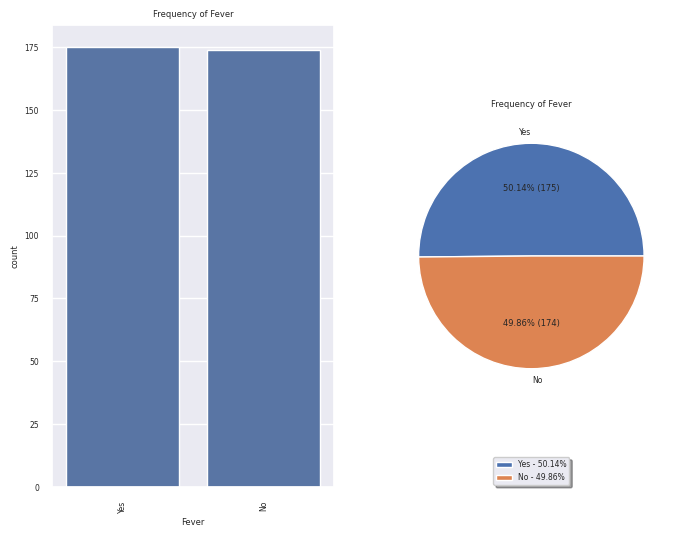

       Cough  Ratio
Cough              
No       182 52.149
Yes      167 47.851


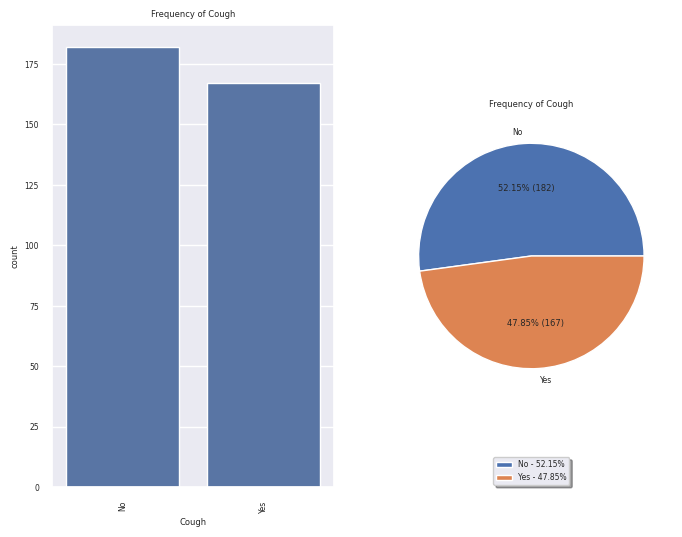

         Fatigue  Ratio
Fatigue                
Yes          242 69.341
No           107 30.659


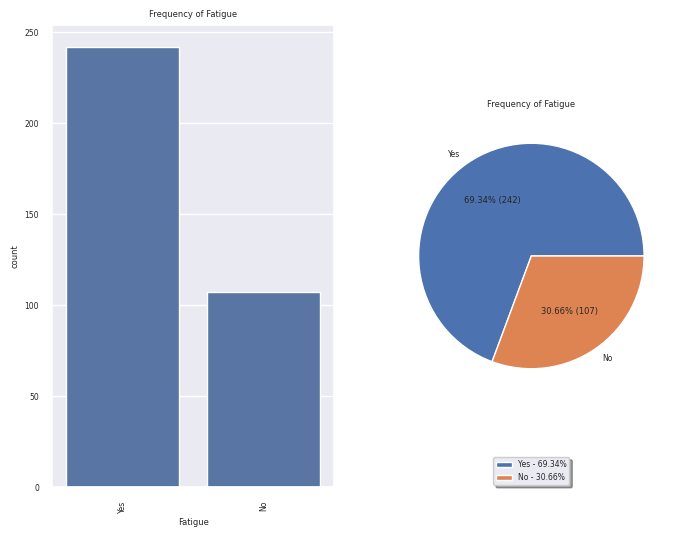

      DB  Ratio
DB             
No   261 74.785
Yes   88 25.215


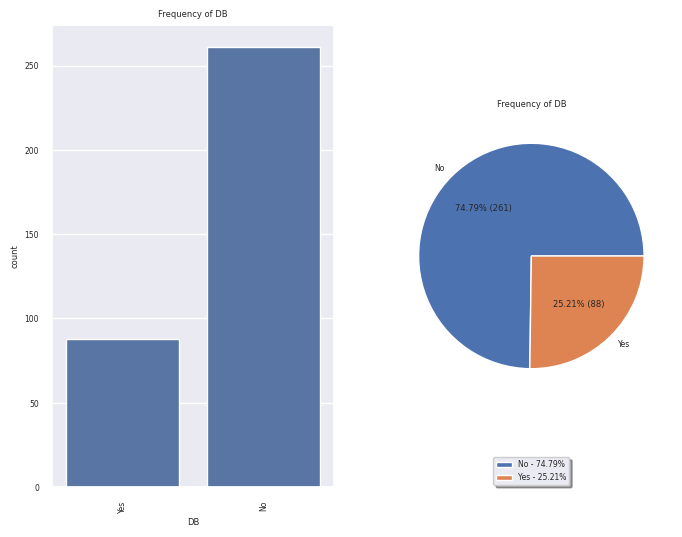

        Gender  Ratio
Gender               
Female     176 50.430
Male       173 49.570


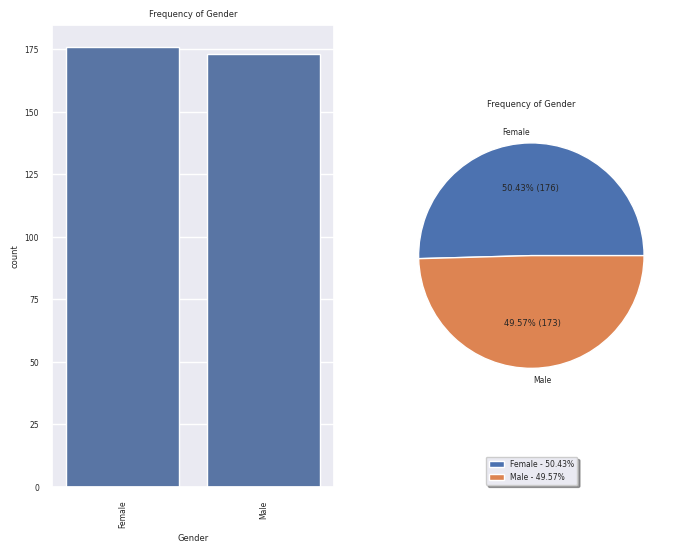

         BP  Ratio
BP                
High    167 47.851
Normal  164 46.991
Low      18  5.158


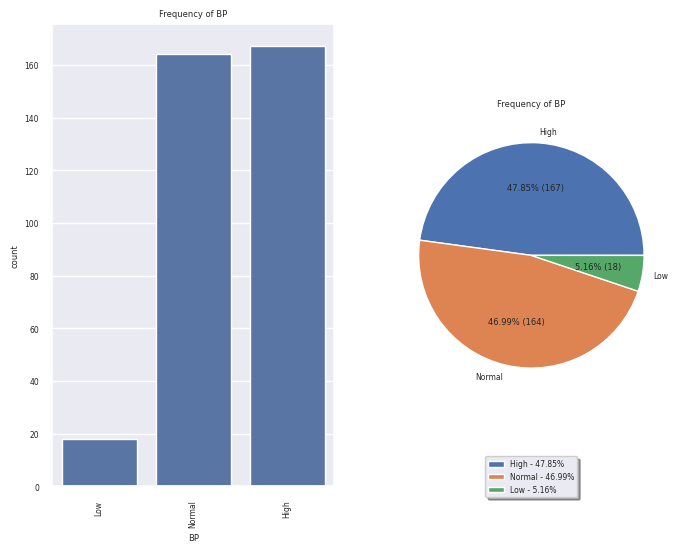

         CL  Ratio
CL                
High    166 47.564
Normal  149 42.693
Low      34  9.742


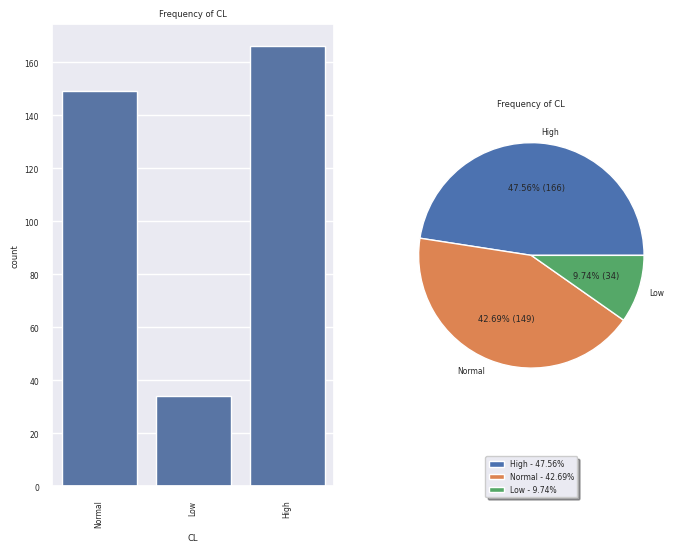

          Results  Ratio
Results                 
Positive      186 53.295
Negative      163 46.705


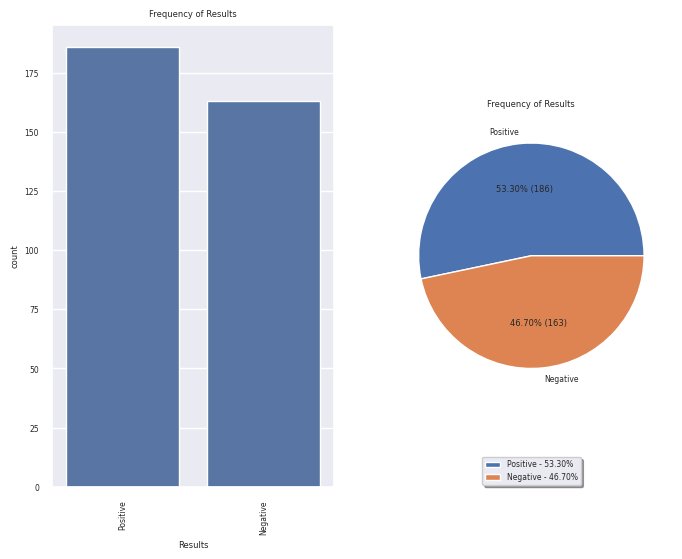

In [89]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(8, 6))
        plt.subplot(1, 2, 1)
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.title("Frequency of " + col_name)
        plt.xticks(rotation=90)

        plt.subplot(1, 2, 2)
        values = dataframe[col_name].value_counts()
        plt.pie(x=values, labels=values.index, autopct=lambda p: '{:.2f}% ({:.0f})'.format(p, p/100 * sum(values)))
        plt.title("Frequency of " + col_name)
        plt.legend(labels=['{} - {:.2f}%'.format(index, value/sum(values)*100) for index, value in zip(values.index, values)],
                   loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=1)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, True)

count   349.000
mean     46.324
std      13.085
min      19.000
5%       29.000
10%      30.000
20%      35.000
30%      38.000
40%      40.000
50%      45.000
60%      50.000
70%      55.000
80%      60.000
90%      65.000
95%      70.000
99%      82.600
max      90.000
Name: Age, dtype: float64


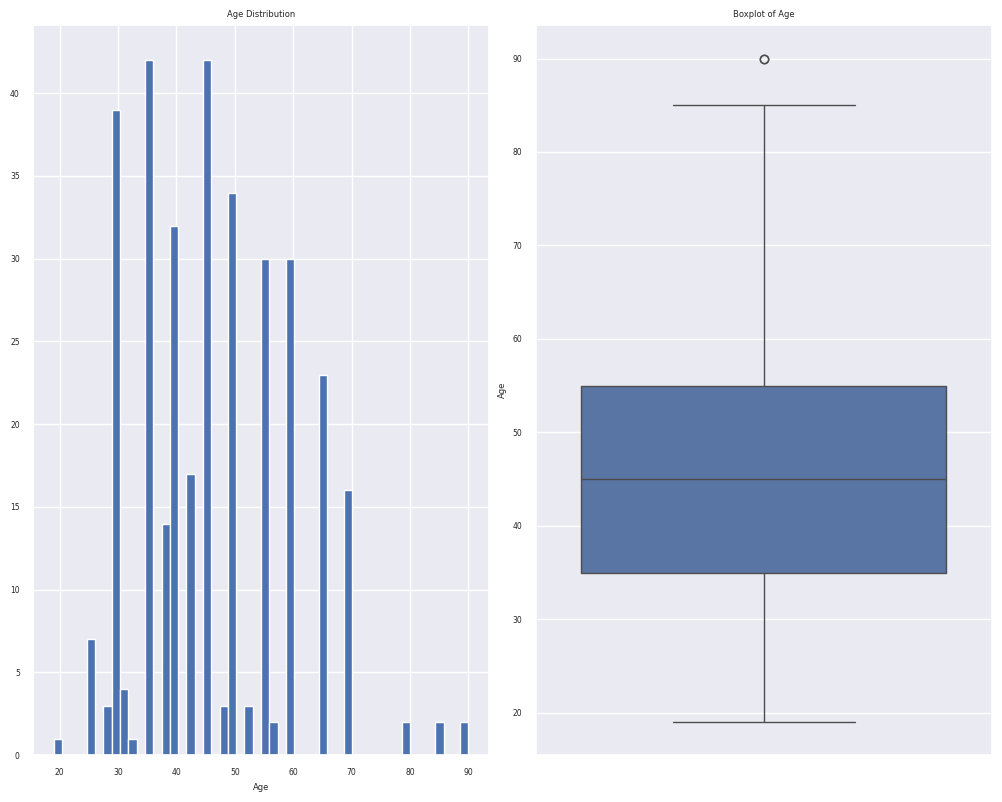

#####################################


In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(10, 8))

        # Histogram
        plt.subplot(1, 2, 1)
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col + ' Distribution')

        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=numerical_col, data=dataframe)
        plt.title("Boxplot of " + numerical_col)
        plt.xticks(rotation=90)

        plt.tight_layout()
        plt.show(block=True)

    print("#####################################")

for col in num_cols:
    num_summary(df, col, plot=True)

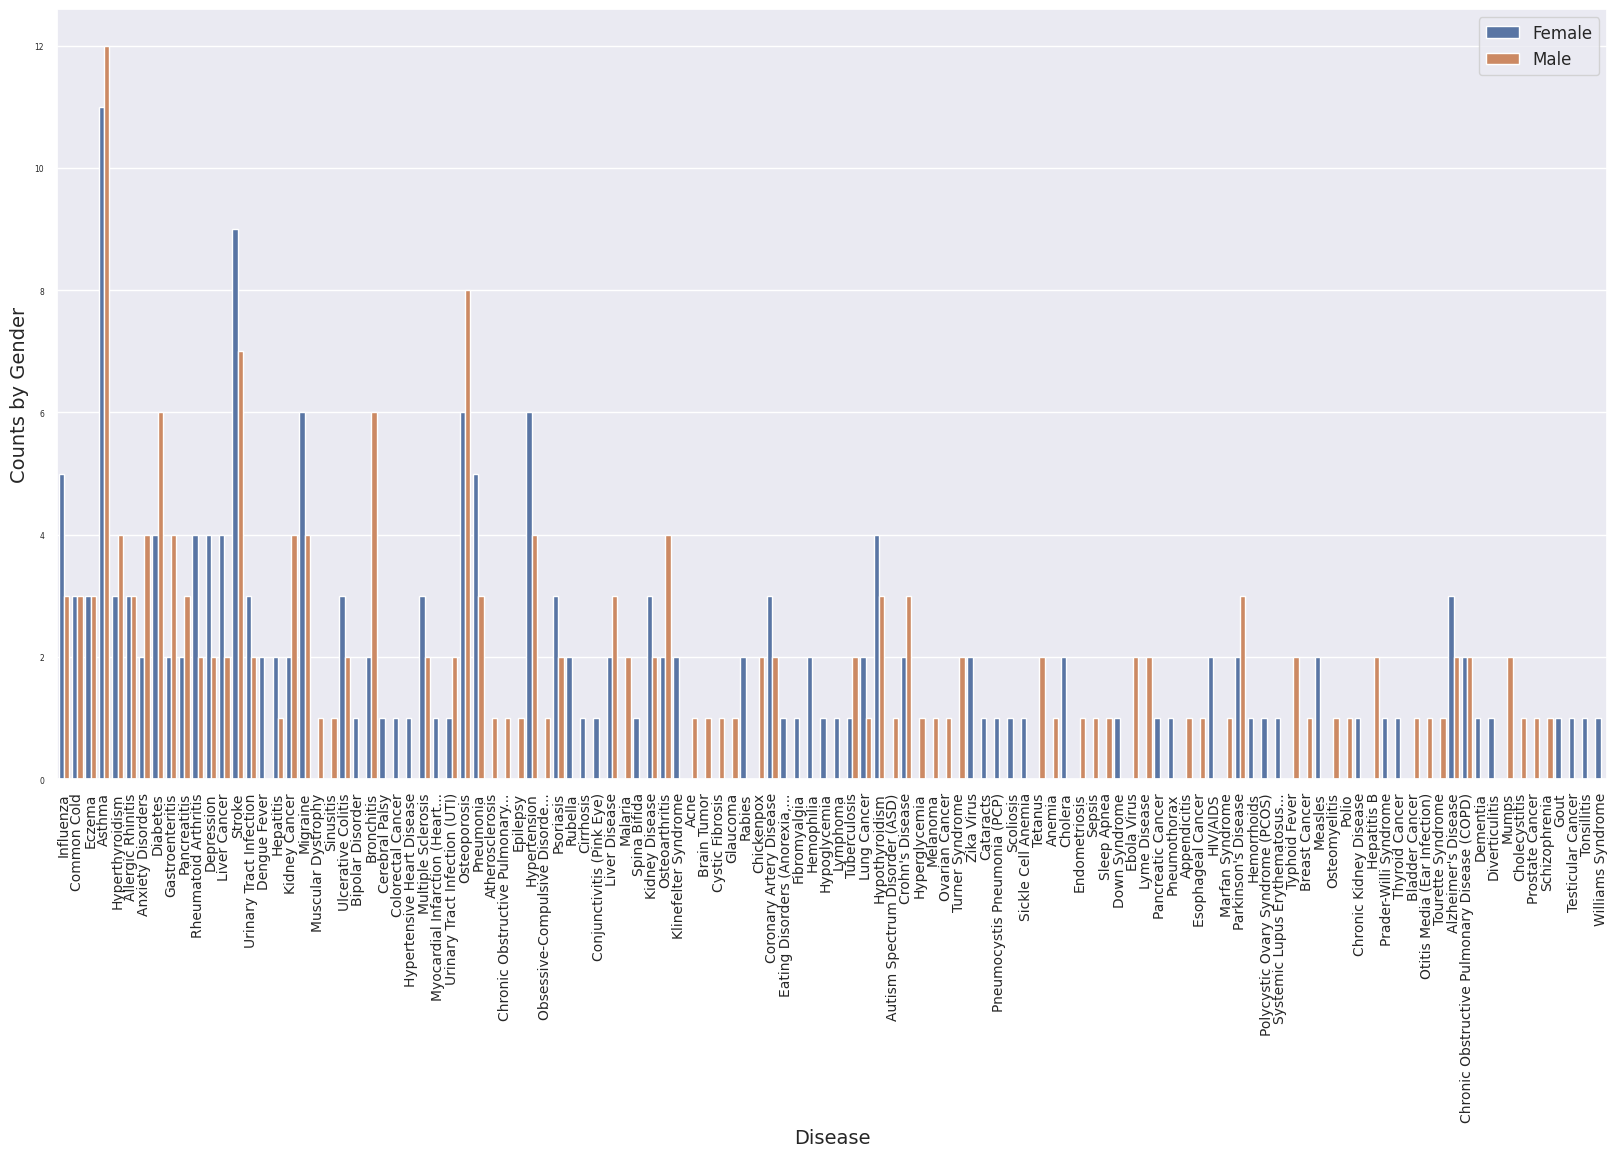

In [91]:
plt.figure(figsize=(20,10))
sns.countplot(x = df['Disease'],hue = df['Gender'])
plt.xticks(rotation=90,fontsize=10)
plt.xlabel('Disease', fontsize=14)
plt.ylabel('Counts by Gender', fontsize=14)
plt.legend(fontsize=12)
plt.show()

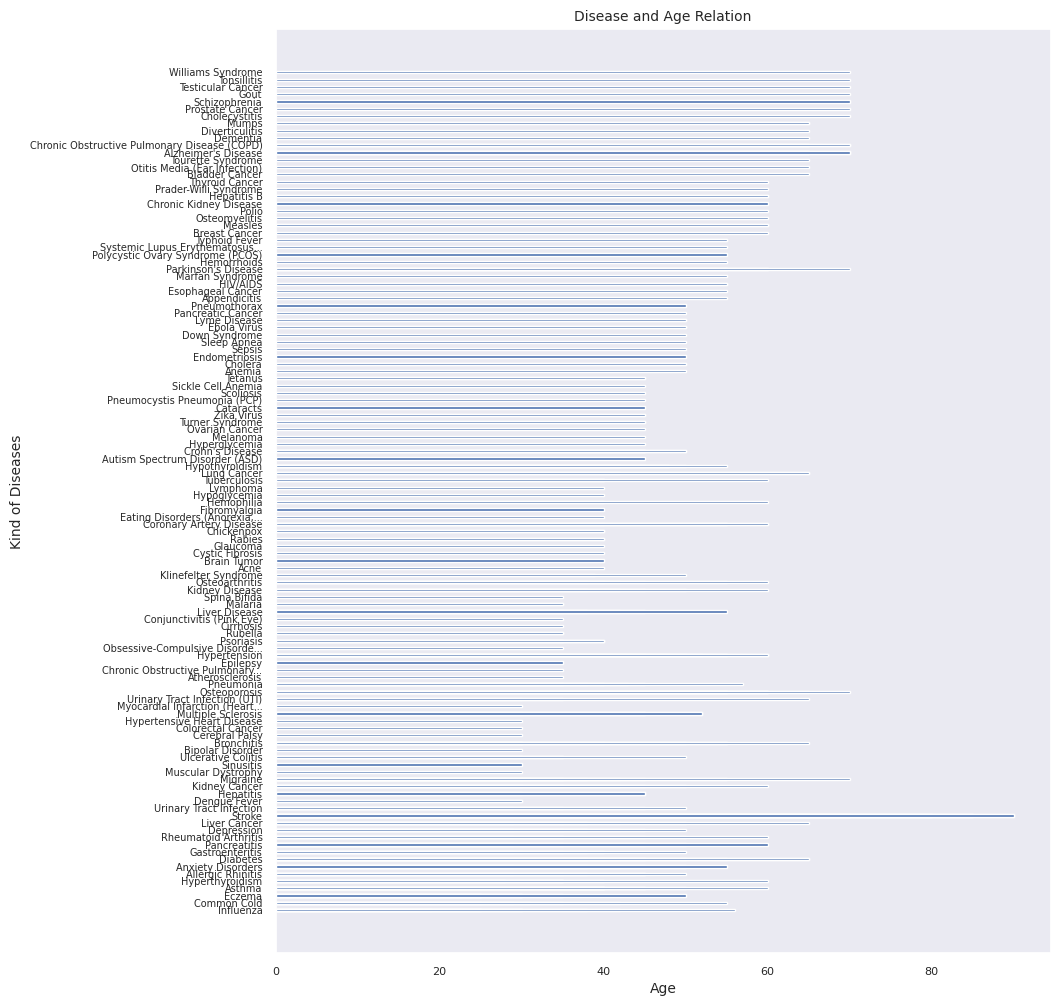

In [92]:
plt.figure(figsize=(10, 12))
plt.barh(df['Disease'], df['Age'], height=0.3, align='center')
plt.xticks(fontsize=8)
plt.yticks(fontsize=7)
plt.xlabel('Age', fontsize=10)
plt.ylabel('Kind of Diseases', fontsize=10)
plt.title('Disease and Age Relation', fontsize=10)
plt.grid()
plt.show()

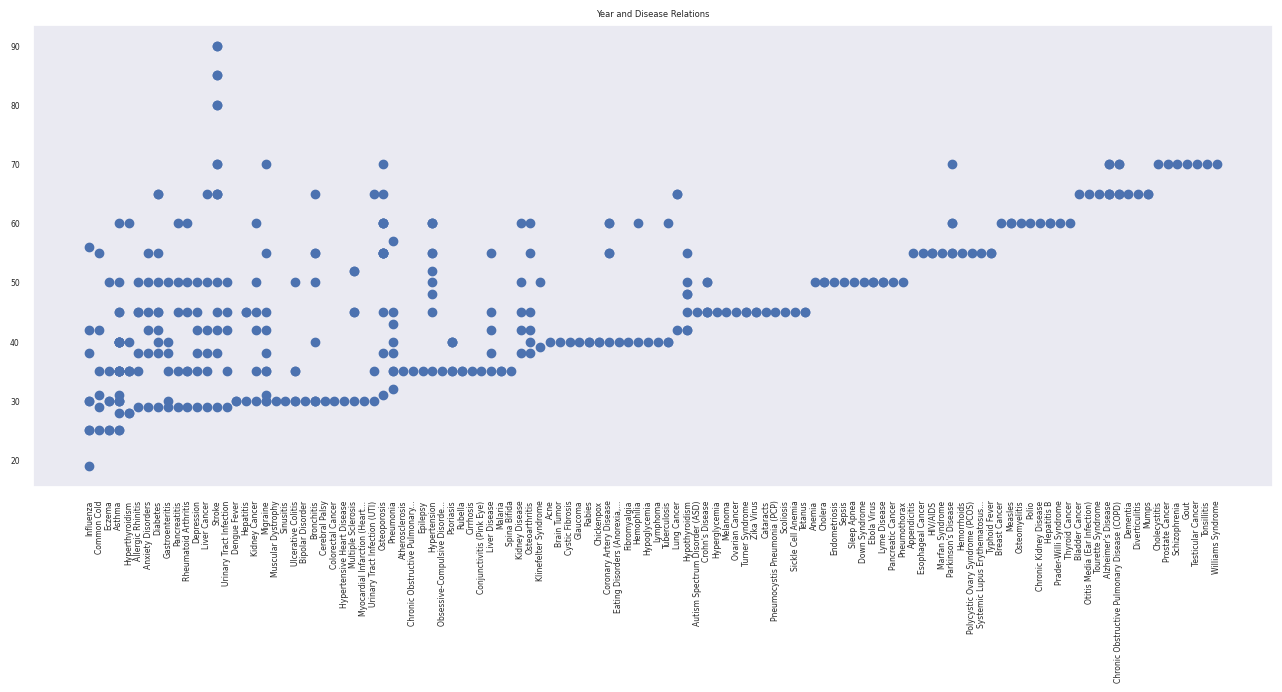

In [93]:
plt.figure(figsize=(16,6))
plt.scatter(df['Disease'],df['Age'])
plt.xticks(rotation=90)
plt.title('Year and Disease Relations')
plt.grid()
plt.show()

In [94]:
df2 = df.copy()

In [95]:
df2.head()

,Disease,Fever,Cough,Fatigue,DB,Age,Gender,BP,CL,Results
0,Influenza,Yes,No,Yes,Yes,19,Female,Low,Normal,Positive
1,Common Cold,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
2,Eczema,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
3,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive
4,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive


In [96]:
le = LabelEncoder()
df2['Fever'] = le.fit_transform(df2['Fever'])
df2['Cough'] = le.fit_transform(df2['Cough'])
df2['Fatigue'] = le.fit_transform(df2['Fatigue'])
df2['DB'] = le.fit_transform(df2['DB'])
df2['Gender'] = le.fit_transform(df2['Gender'])
df2['BP'] = le.fit_transform(df2['BP'])
df2['CL'] = le.fit_transform(df2['CL'])
df2['Results'] = le.fit_transform(df2['Results'])

In [97]:
df2.head()

,Disease,Fever,Cough,Fatigue,DB,Age,Gender,BP,CL,Results
0,Influenza,1,0,1,1,19,0,1,2,1
1,Common Cold,0,1,1,0,25,0,2,2,0
2,Eczema,0,1,1,0,25,0,2,2,0
3,Asthma,1,1,0,1,25,1,2,2,1
4,Asthma,1,1,0,1,25,1,2,2,1


In [98]:
y = df2['Results']
X = df2.drop(['Results','Disease'],axis=1)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
models = [('LR', LogisticRegression()),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()),
          ('RF', RandomForestClassifier()),
          ('GBM', GradientBoostingClassifier()),
          ("XGBoost", XGBClassifier()),
          ("LightGBM", LGBMClassifier(verbose=-1)),
          ("CatBoost", CatBoostClassifier(verbose=False))]

In [101]:
acclist=[]
for name, model in models:
    acc = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy"))
    acclist.append([name,acc])
    print(f"ACC: {round(acc, 4)} ({name}) ")

ACC: 0.6489 (LR) 
ACC: 0.6992 (KNN) 
ACC: 0.7169 (CART) 
ACC: 0.7527 (RF) 
ACC: 0.7099 (GBM) 
ACC: 0.7171 (XGBoost) 
ACC: 0.6777 (LightGBM) 
ACC: 0.7239 (CatBoost) 


In [102]:
cat = CatBoostClassifier(verbose=False)
model = cat.fit(X_train,y_train)
model.score(X_test,y_test)

0.7857142857142857

In [103]:
y_pred = model.predict(X_test)

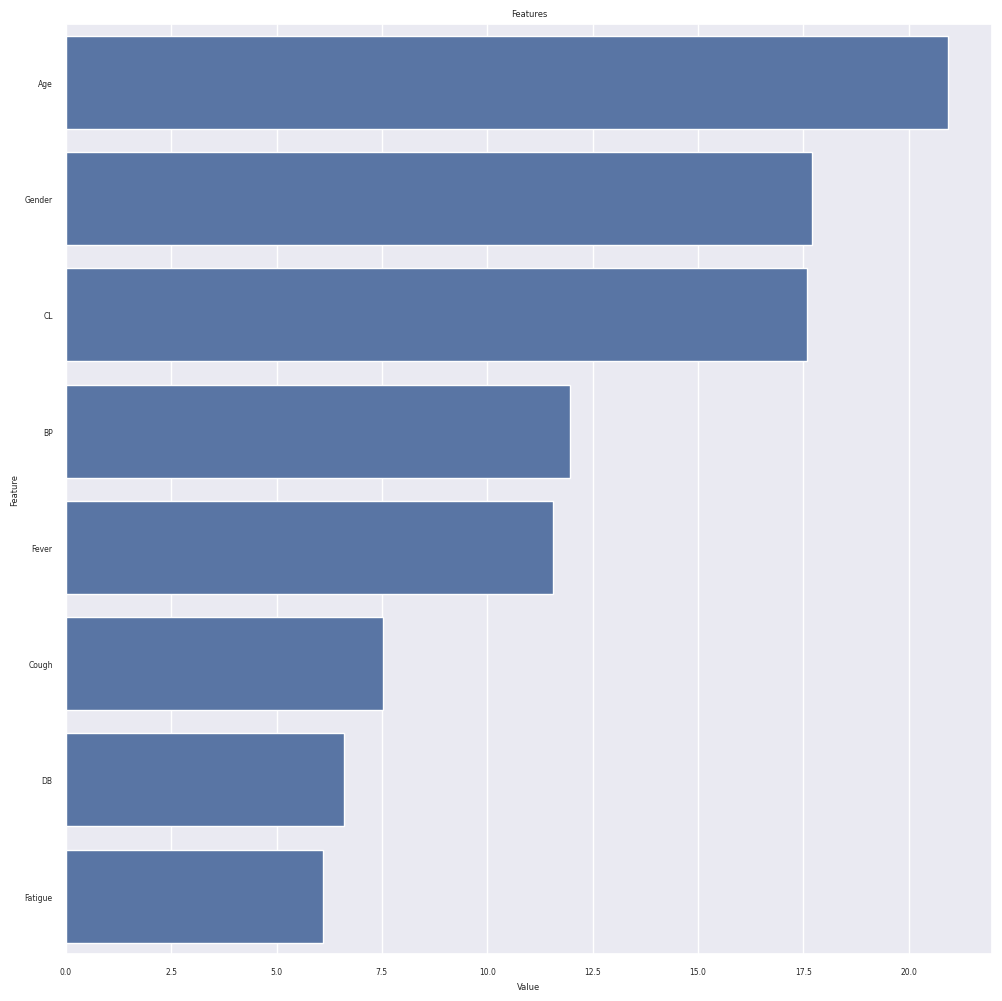

In [104]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=0.5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(model, X)

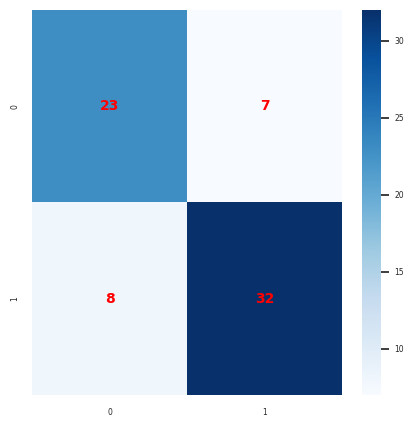

In [105]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap='Blues', fmt='d',annot= True, annot_kws={"size": 10, "weight": "bold", "color":"red"})
plt.show()

In [106]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.77      0.75        30
           1       0.82      0.80      0.81        40

    accuracy                           0.79        70
   macro avg       0.78      0.78      0.78        70
weighted avg       0.79      0.79      0.79        70



In [107]:
roc_auc_score(y_test, y_pred)

0.7833333333333333

In [108]:
df.Disease.unique()

array(['Influenza', 'Common Cold', 'Eczema', 'Asthma', 'Hyperthyroidism',
       'Allergic Rhinitis', 'Anxiety Disorders', 'Diabetes',
       'Gastroenteritis', 'Pancreatitis', 'Rheumatoid Arthritis',
       'Depression', 'Liver Cancer', 'Stroke', 'Urinary Tract Infection',
       'Dengue Fever', 'Hepatitis', 'Kidney Cancer', 'Migraine',
       'Muscular Dystrophy', 'Sinusitis', 'Ulcerative Colitis',
       'Bipolar Disorder', 'Bronchitis', 'Cerebral Palsy',
       'Colorectal Cancer', 'Hypertensive Heart Disease',
       'Multiple Sclerosis', 'Myocardial Infarction (Heart...',
       'Urinary Tract Infection (UTI)', 'Osteoporosis', 'Pneumonia',
       'Atherosclerosis', 'Chronic Obstructive Pulmonary...', 'Epilepsy',
       'Hypertension', 'Obsessive-Compulsive Disorde...', 'Psoriasis',
       'Rubella', 'Cirrhosis', 'Conjunctivitis (Pink Eye)',
       'Liver Disease', 'Malaria', 'Spina Bifida', 'Kidney Disease',
       'Osteoarthritis', 'Klinefelter Syndrome', 'Acne', 'Brain Tumor',


In [109]:
df['Disease'].value_counts()

,count
Disease,
Asthma,23
Stroke,16
Osteoporosis,14
Hypertension,10
Diabetes,10
Migraine,10
Influenza,8
Pneumonia,8
Bronchitis,8


In [110]:
df.groupby(by='Disease').count()

,Fever,Cough,Fatigue,DB,Age,Gender,BP,CL,Results
Disease,,,,,,,,,
Acne,1,1,1,1,1,1,1,1,1
Allergic Rhinitis,6,6,6,6,6,6,6,6,6
Alzheimer's Disease,5,5,5,5,5,5,5,5,5
Anemia,1,1,1,1,1,1,1,1,1
Anxiety Disorders,6,6,6,6,6,6,6,6,6
Appendicitis,1,1,1,1,1,1,1,1,1
Asthma,23,23,23,23,23,23,23,23,23
Atherosclerosis,1,1,1,1,1,1,1,1,1
Autism Spectrum Disorder (ASD),1,1,1,1,1,1,1,1,1


In [111]:
df.Disease.nunique()

116

In [112]:
np.where(df['Disease']=='Influenza'), np.where(df['Disease']=='Eczema')

((array([  0,   6,   7,  45,  46, 100, 146, 272]),),
 (array([  2,   5,  24,  43,  63, 229]),))

In [113]:
df.head()

,Disease,Fever,Cough,Fatigue,DB,Age,Gender,BP,CL,Results
0,Influenza,Yes,No,Yes,Yes,19,Female,Low,Normal,Positive
1,Common Cold,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
2,Eczema,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
3,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive
4,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive


In [114]:
df["Fever_and_Cough"] = (df["Fever"] == "Yes") & (df["Cough"] == "Yes")
df["Fever_and_Fatigue"] = (df["Fever"] == "Yes") & (df["Fatigue"] == "Yes")
df["Fatigue_and_Cough"] = (df["Fatigue"] == "Yes") & (df["Cough"] == "Yes")
df["Fever_and_Fatigue_and_Cough"] = (df['Fever']== "Yes") & (df["Fatigue"] == "Yes") & (df["Cough"] == "Yes")

disease_counts = df["Disease"].value_counts()
df["Disease_Frequency"] = df["Disease"].map(disease_counts)

bins = [0, 18, 65, float('inf')]
labels = ['Child', 'Adult', 'Elderly']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

df['Risk_Score'] = df['Age'] * 0.1 + (df['CL'] == 'High') * 10

df["Age_Squared"] = df["Age"] ** 2

In [115]:
df

,Disease,Fever,Cough,Fatigue,DB,Age,Gender,BP,CL,Results,Fever_and_Cough,Fever_and_Fatigue,Fatigue_and_Cough,Fever_and_Fatigue_and_Cough,Disease_Frequency,Age_Group,Risk_Score,Age_Squared
0,Influenza,Yes,No,Yes,Yes,19,Female,Low,Normal,Positive,False,True,False,False,8,Adult,1.900,361
1,Common Cold,No,Yes,Yes,No,25,Female,Normal,Normal,Negative,False,False,True,False,6,Adult,2.500,625
2,Eczema,No,Yes,Yes,No,25,Female,Normal,Normal,Negative,False,False,True,False,6,Adult,2.500,625
3,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive,True,False,False,False,23,Adult,2.500,625
4,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive,True,False,False,False,23,Adult,2.500,625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,Stroke,Yes,No,Yes,No,80,Female,High,High,Positive,False,True,False,False,16,Elderly,18.000,6400
345,Stroke,Yes,No,Yes,No,85,Male,High,High,Positive,False,True,False,False,16,Elderly,18.500,7225
346,Stroke,Yes,No,Yes,No,85,Male,High,High,Positive,False,True,False,False,16,Elderly,18.500,7225
347,Stroke,Yes,No,Yes,No,90,Female,High,High,Positive,False,True,False,False,16,Elderly,19.000,8100


In [116]:
dfd = pd.get_dummies(df,columns=['Fever','Cough','Fatigue','DB','BP','CL','Gender','Age_Group'],drop_first=True)

In [117]:
dfd.head()

,Disease,Age,Results,Fever_and_Cough,Fever_and_Fatigue,Fatigue_and_Cough,Fever_and_Fatigue_and_Cough,Disease_Frequency,Risk_Score,Age_Squared,Fever_Yes,Cough_Yes,Fatigue_Yes,DB_Yes,BP_Low,BP_Normal,CL_Low,CL_Normal,Gender_Male,Age_Group_Adult,Age_Group_Elderly
0,Influenza,19,Positive,False,True,False,False,8,1.900,361,True,False,True,True,True,False,False,True,False,True,False
1,Common Cold,25,Negative,False,False,True,False,6,2.500,625,False,True,True,False,False,True,False,True,False,True,False
2,Eczema,25,Negative,False,False,True,False,6,2.500,625,False,True,True,False,False,True,False,True,False,True,False
3,Asthma,25,Positive,True,False,False,False,23,2.500,625,True,True,False,True,False,True,False,True,True,True,False
4,Asthma,25,Positive,True,False,False,False,23,2.500,625,True,True,False,True,False,True,False,True,True,True,False


In [118]:
dfd.shape

(349, 21)

In [119]:
np.where(dfd.isna())

(array([], dtype=int64), array([], dtype=int64))

In [120]:
dfd.columns.values

array(['Disease', 'Age', 'Results', 'Fever_and_Cough',
       'Fever_and_Fatigue', 'Fatigue_and_Cough',
       'Fever_and_Fatigue_and_Cough', 'Disease_Frequency', 'Risk_Score',
       'Age_Squared', 'Fever_Yes', 'Cough_Yes', 'Fatigue_Yes', 'DB_Yes',
       'BP_Low', 'BP_Normal', 'CL_Low', 'CL_Normal', 'Gender_Male',
       'Age_Group_Adult', 'Age_Group_Elderly'], dtype=object)

In [121]:
dfd.rename(columns={
    "Disease_Alzheimer's Disease": "Disease_Alzheimers_Disease",
    "Disease_Anxiety Disorders": "Disease_Anxiety_Disorders",
    "Disease_Autism Spectrum Disorder (ASD)": "Disease_Autism_Spectrum_Disorder",
    "Disease_Bipolar Disorder": "Disease_Bipolar_Disorder",
    "Disease_Bladder Cancer": "Disease_Bladder_Cancer",
    "Disease_Brain Tumor": "Disease_Brain_Tumor",
    "Disease_Breast Cancer": "Disease_Breast_Cancer",
    "Disease_Cerebral Palsy": "Disease_Cerebral_Palsy",
    "Disease_Chronic Kidney Disease": "Disease_Chronic_Kidney_Disease",
    "Disease_Chronic Obstructive Pulmonary Disease (COPD)": "Disease_Chronic_Obstructive_Pulmonary_Disease",
    "Disease_Chronic Obstructive Pulmonary...": "Disease_Chronic_Obstructive_Pulmonary_Disease_COPD",
    "Disease_Colorectal Cancer": "Disease_Colorectal_Cancer",
    "Disease_Common Cold": "Disease_Common_Cold",
    "Disease_Conjunctivitis (Pink Eye)": "Disease_Conjunctivitis_Pink_Eye",
    "Disease_Coronary Artery Disease": "Disease_Coronary_Artery_Disease",
    "Disease_Crohn's Disease": "Disease_Crohns_Disease",
    "Disease_Cystic Fibrosis": "Disease_Cystic_Fibrosis",
    "Disease_Dengue Fever": "Disease_Dengue_Fever",
    "Disease_Down Syndrome": "Disease_Down_Syndrome",
    "Disease_Eating Disorders (Anorexia,...": "Disease_Eating_Disorders_Anorexia",
    "Disease_Ebola Virus": "Disease_Ebola_Virus",
    "Disease_Esophageal Cancer": "Disease_Esophageal_Cancer",
    "Disease_Hypertensive Heart Disease": "Disease_Hypertensive_Heart_Disease",
    "Disease_Kidney Cancer": "Disease_Kidney_Cancer",
    "Disease_Kidney Disease": "Disease_Kidney_Disease",
    "Disease_Klinefelter Syndrome": "Disease_Klinefelter_Syndrome",
    "Disease_Liver Cancer": "Disease_Liver_Cancer",
    "Disease_Liver Disease": "Disease_Liver_Disease",
    "Disease_Lung Cancer": "Disease_Lung_Cancer",
    "Disease_Lyme Disease": "Disease_Lyme_Disease",
    "Disease_Marfan Syndrome": "Disease_Marfan_Syndrome",
    "Disease_Multiple Sclerosis": "Disease_Multiple_Sclerosis",
    "Disease_Muscular Dystrophy": "Disease_Muscular_Dystrophy",
    "Disease_Myocardial Infarction (Heart...": "Disease_Myocardial_Infarction_Heart",
    "Disease_Obsessive-Compulsive Disorde...": "Disease_Obsessive_Compulsive_Disorder",
    "Disease_Otitis Media (Ear Infection)": "Disease_Otitis_Media_Ear_Infection",
    "Disease_Ovarian Cancer": "Disease_Ovarian_Cancer",
    "Disease_Pancreatic Cancer": "Disease_Pancreatic_Cancer",
    "Disease_Parkinson's Disease": "Disease_Parkinsons_Disease",
    "Disease_Pneumocystis Pneumonia (PCP)": "Disease_Pneumocystis_Pneumonia_PCP",
    "Disease_Polycystic Ovary Syndrome (PCOS)": "Disease_Polycystic_Ovary_Syndrome_PCOS",
    "Disease_Prader-Willi Syndrome": "Disease_Prader_Willi_Syndrome",
    "Disease_Prostate Cancer": "Disease_Prostate_Cancer",
    "Disease_Rheumatoid Arthritis": "Disease_Rheumatoid_Arthritis",
    "Disease_Sickle Cell Anemia": "Disease_Sickle_Cell_Anemia",
    "Disease_Sleep Apnea": "Disease_Sleep_Apnea",
    "Disease_Spina Bifida": "Disease_Spina_Bifida",
    "Disease_Systemic Lupus Erythematosus...": "Disease_Systemic_Lupus_Erythematosus",
    "Disease_Testicular Cancer": "Disease_Testicular_Cancer",
    "Disease_Thyroid Cancer": "Disease_Thyroid_Cancer",
    "Disease_Tourette Syndrome": "Disease_Tourette_Syndrome",
    "Disease_Turner Syndrome": "Disease_Turner_Syndrome",
    "Disease_Typhoid Fever": "Disease_Typhoid_Fever",
    "Disease_Ulcerative Colitis": "Disease_Ulcerative_Colitis",
    "Disease_Urinary Tract Infection": "Disease_Urinary_Tract_Infection",
    "Disease_Urinary Tract Infection (UTI)": "Disease_Urinary_Tract_Infection_UTI",
    "Disease_Williams Syndrome": "Disease_Williams_Syndrome",
    "Disease_Zika Virus": "Disease_Zika_Virus"
}, inplace=True)

In [122]:
le = LabelEncoder()
dfd['Results'] = le.fit_transform(dfd['Results'])
dfd['Fever_and_Cough'] = le.fit_transform(dfd['Fever_and_Cough'])
dfd['Fever_and_Fatigue'] = le.fit_transform(dfd['Fever_and_Fatigue'])
dfd['Fatigue_and_Cough'] = le.fit_transform(dfd['Fatigue_and_Cough'])
dfd['Fever_and_Fatigue_and_Cough'] = le.fit_transform(dfd['Fever_and_Fatigue_and_Cough'])
dfd['Fever_and_Cough'] = le.fit_transform(dfd['Fever_and_Cough'])

In [123]:
dfd.head()

,Disease,Age,Results,Fever_and_Cough,Fever_and_Fatigue,Fatigue_and_Cough,Fever_and_Fatigue_and_Cough,Disease_Frequency,Risk_Score,Age_Squared,Fever_Yes,Cough_Yes,Fatigue_Yes,DB_Yes,BP_Low,BP_Normal,CL_Low,CL_Normal,Gender_Male,Age_Group_Adult,Age_Group_Elderly
0,Influenza,19,1,0,1,0,0,8,1.900,361,True,False,True,True,True,False,False,True,False,True,False
1,Common Cold,25,0,0,0,1,0,6,2.500,625,False,True,True,False,False,True,False,True,False,True,False
2,Eczema,25,0,0,0,1,0,6,2.500,625,False,True,True,False,False,True,False,True,False,True,False
3,Asthma,25,1,1,0,0,0,23,2.500,625,True,True,False,True,False,True,False,True,True,True,False
4,Asthma,25,1,1,0,0,0,23,2.500,625,True,True,False,True,False,True,False,True,True,True,False


In [124]:
dfd.drop('Disease',axis=1,inplace=True)

In [125]:
y = dfd['Results']
X = dfd.drop('Results',axis=1)

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [127]:
X_train

,Age,Fever_and_Cough,Fever_and_Fatigue,Fatigue_and_Cough,Fever_and_Fatigue_and_Cough,Disease_Frequency,Risk_Score,Age_Squared,Fever_Yes,Cough_Yes,Fatigue_Yes,DB_Yes,BP_Low,BP_Normal,CL_Low,CL_Normal,Gender_Male,Age_Group_Adult,Age_Group_Elderly
228,50,1,1,1,1,2,5.000,2500,True,True,True,True,False,True,False,True,True,True,False
78,35,0,0,0,0,1,13.500,1225,False,True,False,False,False,False,False,False,False,True,False
90,35,0,0,0,0,5,13.500,1225,False,False,True,False,False,True,False,False,True,True,False
16,29,0,0,0,0,5,2.900,841,True,False,False,False,False,False,False,True,False,True,False
66,35,1,1,1,1,7,3.500,1225,True,True,True,False,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,45,0,0,1,0,10,14.500,2025,False,True,True,False,False,True,False,False,True,True,False
71,35,0,0,1,0,5,3.500,1225,False,True,True,False,False,True,True,False,False,True,False
106,38,0,1,0,0,6,13.800,1444,True,False,True,True,False,False,False,False,True,True,False
270,55,0,0,0,0,2,5.500,3025,False,True,False,False,False,True,True,False,True,True,False


In [128]:
y_train

,Results
228,1
78,1
90,1
16,0
66,0
...,...
188,1
71,0
106,1
270,1


In [129]:
scaler = MinMaxScaler()
dfd[["Age","Age_Squared","Disease_Frequency","Risk_Score"]] = scaler.fit_transform(dfd[["Age","Age_Squared","Disease_Frequency","Risk_Score"]])
dfd.head()

,Age,Results,Fever_and_Cough,Fever_and_Fatigue,Fatigue_and_Cough,Fever_and_Fatigue_and_Cough,Disease_Frequency,Risk_Score,Age_Squared,Fever_Yes,Cough_Yes,Fatigue_Yes,DB_Yes,BP_Low,BP_Normal,CL_Low,CL_Normal,Gender_Male,Age_Group_Adult,Age_Group_Elderly
0,0.000,1,0,1,0,0,0.318,0.000,0.000,True,False,True,True,True,False,False,True,False,True,False
1,0.085,0,0,0,1,0,0.227,0.035,0.034,False,True,True,False,False,True,False,True,False,True,False
2,0.085,0,0,0,1,0,0.227,0.035,0.034,False,True,True,False,False,True,False,True,False,True,False
3,0.085,1,1,0,0,0,1.000,0.035,0.034,True,True,False,True,False,True,False,True,True,True,False
4,0.085,1,1,0,0,0,1.000,0.035,0.034,True,True,False,True,False,True,False,True,True,True,False


In [130]:
models = [('LR', LogisticRegression()),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()),
          ('RF', RandomForestClassifier()),
          ('GBM', GradientBoostingClassifier()),
          ("XGBoost", XGBClassifier()),
          ("LightGBM", LGBMClassifier(verbose=-1)),
          ("CatBoost", CatBoostClassifier(verbose=False))]

In [131]:
acclist=[]
for name, model in models:
    acc = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy"))
    acclist.append([name,acc])
    print(f"ACC: {round(acc, 4)} ({name}) ")

ACC: 0.6919 (LR) 
ACC: 0.6345 (KNN) 
ACC: 0.7137 (CART) 
ACC: 0.7742 (RF) 
ACC: 0.7386 (GBM) 
ACC: 0.7707 (XGBoost) 
ACC: 0.7279 (LightGBM) 
ACC: 0.7886 (CatBoost) 


In [132]:
cat = CatBoostClassifier(verbose=False)
model1 = cat.fit(X_train,y_train)
model1.score(X_test,y_test)

0.8714285714285714

In [133]:
y_pred = model1.predict(X_test)

In [134]:
y_pred

array([1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1])

In [135]:
y_test

,Results
157,1
341,1
315,1
234,1
155,1
274,0
304,0
227,1
278,0
185,1


In [136]:
accuracy_score(y_test, y_pred)

0.8714285714285714

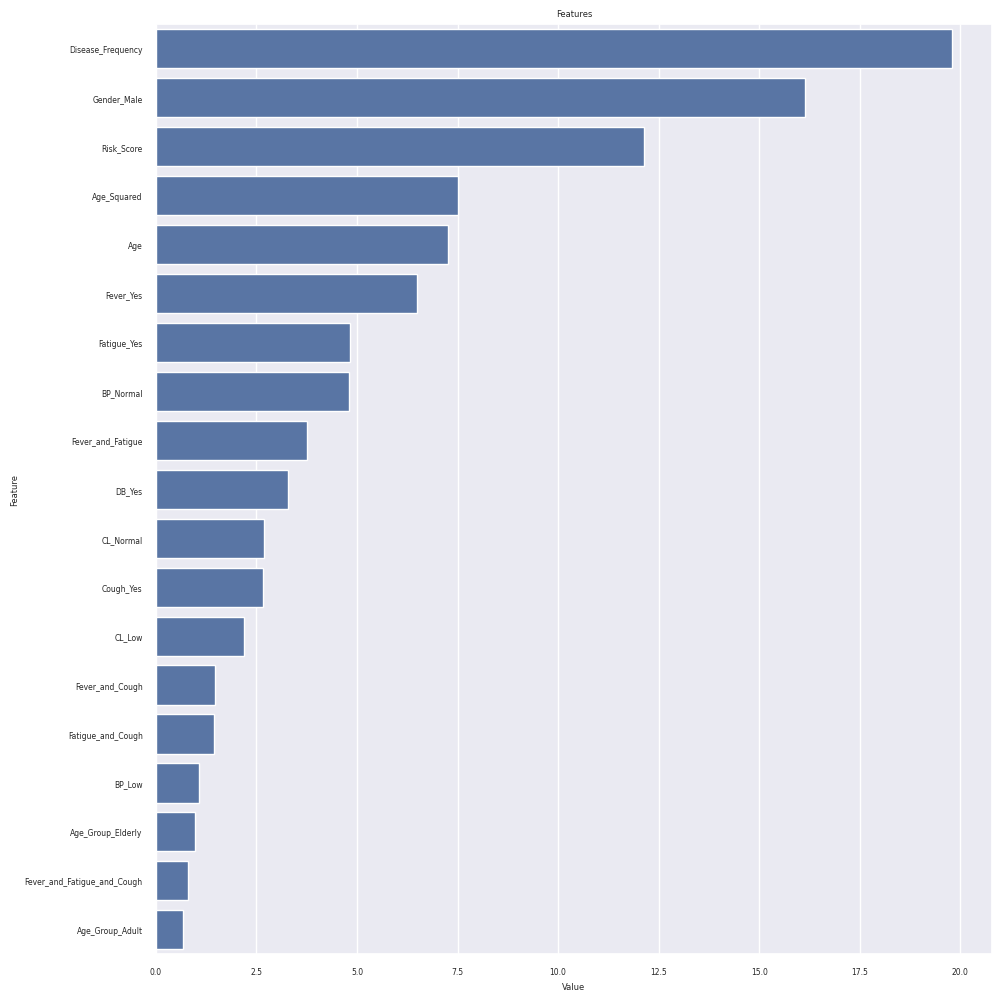

In [137]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=0.5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(model1, X)

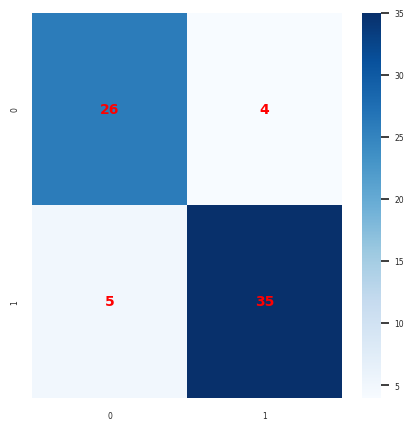

In [138]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap='Blues', fmt='d',annot= True, annot_kws={"size": 10, "weight": "bold", "color":"red"})
plt.show()

In [139]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85        30
           1       0.90      0.88      0.89        40

    accuracy                           0.87        70
   macro avg       0.87      0.87      0.87        70
weighted avg       0.87      0.87      0.87        70



In [140]:
catboost = CatBoostClassifier(verbose=False, random_state=42)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'iterations': [200, 300,500]
}

In [141]:
grid_search = GridSearchCV(estimator=catboost, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1).fit(X_train, y_train)

In [142]:
best_params = grid_search.best_params_
best_params

{'depth': 4, 'iterations': 300, 'learning_rate': 0.05}

In [143]:
final_cat = catboost.set_params(**best_params).fit(X_train, y_train)

In [144]:
y_pred_cat = final_cat.predict(X_test)
acc = round(accuracy_score(y_test,y_pred_cat), 4)*100
print("Accuacy:", acc)

Accuacy: 87.14


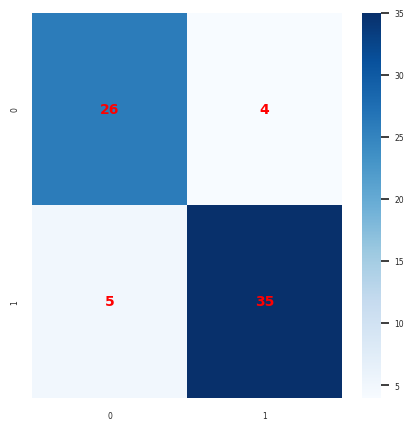

In [145]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred_cat), cmap='Blues', fmt='d',annot= True, annot_kws={"size": 10, "weight": "bold", "color":"red"})
plt.show()

In [146]:
print(classification_report(y_test, y_pred_cat))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85        30
           1       0.90      0.88      0.89        40

    accuracy                           0.87        70
   macro avg       0.87      0.87      0.87        70
weighted avg       0.87      0.87      0.87        70

